# An Investigation of the Pharmacogenomic Effects of a Chalcone Hit to Promote Resistance Against Oxidative Stress in Human WI-38 Cells

# 12/13/19 Anmol Seth and Pranav Bhimani

# Data Loading and Introduction

In [5]:
# Load the modules we'll need
from datascience import *
import numpy as np
import random
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
plt.style.use('fivethirtyeight')
from client.api.notebook import Notebook
from scipy.spatial.distance import cdist

In [6]:
seq_data = pd.read_csv('GSE141675_matrix.original_names.csv')

Citation: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE141675

For our project, we conducted an investigation into the pharmacogenomic effects of a chalcone hit to promote resistance against oxidative stress in human WI-38 cells. 

Oxidative stress is an imbalance of free radicals and antioxidants in the human body which leads to cell and tissue damage. Oxidative stress is a naturally occurring process in the human body that plays a key role in the aging process. Our research study holds significance in regards to diminishing the negative effects of oxidative stress which are tied to numerous chronic conditions such as cancer, diabetes, and heart disease. 

We pulled a data set from NCBI Gene Expression Omnibus which conducted gene expression profiling by high throughput sequencing. This dataset contained data from a human WI-38 fibroblast cell line treated with a chalcone that is hypothesized to promote resistance to hydrogen peroxide. 

Cells were then subjected to treatment with 0.1% DMSO (control), or 10uM Gr-4D (Gr-4D-CB, from ChemBridge; or Gr-4D-MP, from MolPort), or no treatment for 24 hours. WI-38 cells of mid-age (PDL ~32) were cultured in OptiMEM (Invitrogen) supplemented with 10% FBS in a 37C incubator (5% CO2, 21% O2) to ~70%. Cells were rinsed briefly with PBS and frozen with liquid nitrogen and stored at -80C before processed for the isolation of total RNA. Total RNA was isolated and purified using the RNeasy kit (Qiagen), with on-column DNase digest. Illumina TruSeq RNA Sample Prep Kit was used for the construction of sequencing libraries from 375 ng of total RNA.

The dataset that was used was an imported CSV file which contained gene counts. Genes that showed significant change of expression (normalized to DMSO control-treated samples) were obtained using SAM with a false discovery rate <0.10, 1.5 fold. Given this information, there was no need for data cleaning and normalization. 

However, it is important to mention the importance of this data normalization. Normalization is used to remove anomalies and compare all data values on a similar scale so meaningful conclusions may be drawn. These variances between different samples or datasets could result from variance in the number of captured cells, the amplification process, and more. This is particularly important when analyzing replicate samples which is the case here where we saw one baseline and three different treatments used. Each of those were run in quadruplicate to validate repeatability and reproducibility of the study design. There are several forms of data normalization such as TPM normalization and median normalization - each with their own strengths and weaknesses. 



# Visualization

We first begin with a simple visualization to see what we are working with by plotting the number of genes "expressed" per sample


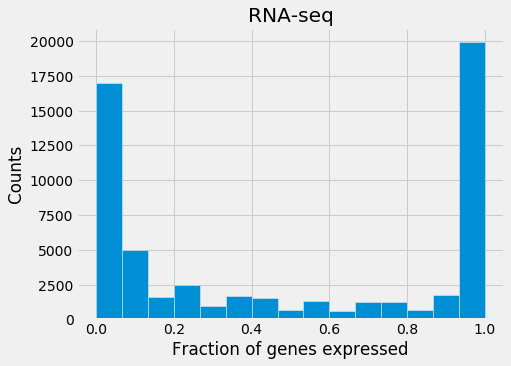

In [7]:
plt.figure(figsize=(15,5))

plt.subplot(121)
avg_genes_per_sample = (seq_data.iloc[:,1:] > 0).mean(axis=1)
plt.hist(avg_genes_per_sample, bins = 15)
plt.title("RNA-seq") 
plt.xlabel('Fraction of genes expressed')
plt.ylabel('Counts');

# PCA with k-means Analysis

Initially, we were going to use a Principal Component Analysis as an unsupervised algorithm to group the data and discover correlations. We wanted to use it to emphasize variation and bring out any patterns present in the data set. However, since our data set did not include the true labels of the data, we used the k-means clustering algorithm which labels the cells as belonging to a cluster and we specified the total number of clusters. After reading the study’s design and methodology, we knew that there would be 4 clusters since there were two treatment options and one control, and one no treatment. After running the k-means clustering algorithm, we saw clean and clear separation between 4 groupings which emphasizes the unique impact of each treatment option compared to the control and no treatment. This also showed that the data we were working with was good data due to clear, discrete groupings. This helped us confirm that there were significant differences in grouping when comparing the 4 treatment options that were used.


In [8]:
x = StandardScaler().fit_transform(seq_data.iloc[:,1:].T)
pca = PCA(n_components = 24)
principalComponents = pca.fit_transform(x)

In [9]:
tsne = TSNE(n_components = 2)
X_embedded = tsne.fit_transform(principalComponents)

In [10]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_embedded)
predictions = kmeans.predict(X_embedded)

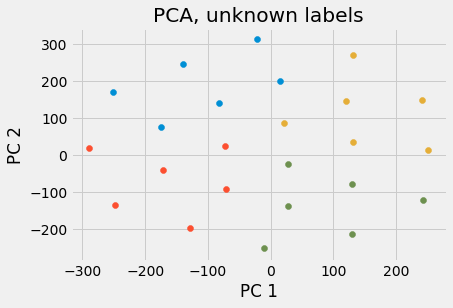

In [11]:
plt.scatter(X_embedded[predictions == 0,0], X_embedded[predictions == 0,1])
plt.scatter(X_embedded[predictions == 1,0], X_embedded[predictions == 1,1]) # Plot cluster 1
plt.scatter(X_embedded[predictions == 2,0], X_embedded[predictions == 2,1])
plt.scatter(X_embedded[predictions == 3,0], X_embedded[predictions == 3,1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA, unknown labels')
plt.show()

# Rank-Sum Tests

Next, we created a scatter plot which of the average expression for each gene in the treated versus the control sample. However, it was difficult to identify differentially expressed genes using this scatter plot.

In [12]:
transposed = seq_data.iloc[:,1:].T
control_only = transposed.iloc[0:6]

In [13]:
mean_exp_control = np.mean(control_only, axis = 0)
treated_only = transposed.drop(transposed.index[12:18]).drop(transposed.index[0:6])
mean_exp_treated = np.mean(treated_only, axis = 0)

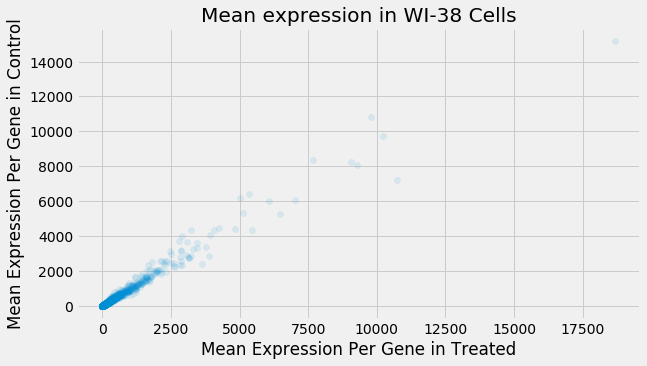

In [14]:
plt.figure(figsize=(9,5))
plt.scatter(mean_exp_treated, mean_exp_control ,alpha=0.1)
plt.ylabel('Mean Expression Per Gene in Control')
plt.xlabel('Mean Expression Per Gene in Treated')
plt.title('Mean expression in WI-38 Cells')
plt.show()

As a result, we ran a Mann-Whitney test to isolate and identify differentially expressed genes when comparing treated samples against the control cell line which was treated with DMSO. This validated the efficacy of using a chalcone hit to promote resistance against oxidative stress. We were able to quantify the impact of approach by looking at changes in gene expression. Out of the 57443 genes analyzed, we identified 8991 genes which expressed statistically significant changes in gene expression with a p-value of 0.05.


In [15]:
gene_p_vals = []
drop_list = []
for x in np.arange(0, control_only.shape[1]):
    control_gene_data = control_only.iloc[:,x]
    treated_gene_data = treated_only.iloc[:,x]
    if sum(control_gene_data) != 0 and sum(treated_gene_data) != 0:
        p_val = stats.mannwhitneyu(control_gene_data, treated_gene_data)[1]
        gene_p_vals.append(p_val)
    else:
        drop_list.append(x)
        
        
    
len(gene_p_vals)


35821

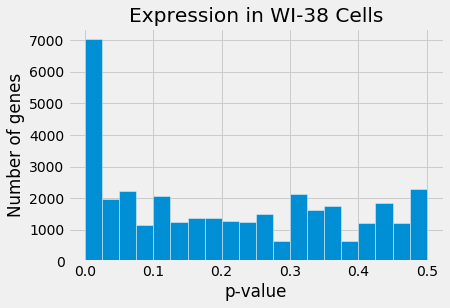

In [16]:
plt.hist(gene_p_vals, bins = 20)
plt.xlabel('p-value')
plt.ylabel('Number of genes')
plt.title('Expression in WI-38 Cells')
plt.show()

In [17]:
n_genes_de = np.sum(np.array(gene_p_vals) <= 0.05)
n_genes_de

8991

In [18]:
updated_seq_data = seq_data.drop(drop_list)
updated_seq_data['p-values between treated and untreated'] = gene_p_vals
updated_seq_data = updated_seq_data[['gene_id', 'p-values between treated and untreated']]

In [19]:
only_sig_genes = updated_seq_data[updated_seq_data["p-values between treated and untreated"]<= 0.05]
final_significant_genes = only_sig_genes['gene_id']
final_genes_in_list = final_significant_genes.tolist()

In final_genes_in_list, we are able to isolate and identify 8991 genes of interest which experience significant changes in gene expression in response to the treatment. Due to constraints, we were not able to study all 8991 genes but we did choose to select one of the genes and explore its function in the oxidation stress to ensure the treatment was targetting the right locations. ENSG00000101882.9 is one of these genes which is an NFKB activating protein. Secondary research reveals that this gene plays a key role when it comes to oxidation stress. 

"NF-κB may play a protective role under conditions of oxidative stress by suppressing ROS accumulation. Inhibition of NF-κB activation results in an increase in TNFα-induced ROS production, lipid peroxidation and protein oxidation [33]. Modulation of autophagy may be another NF-κB mediated protective mechanism. In retinal pigment epithelial cells under H2O2 induced oxidative stress, NFκB p65 phosphorylation at Ser-536 was found to be critical for p62 upregulation, which promotes autophagy. A decrease in autophagy rendered the cells more susceptible to oxidative damage [34]."
Source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5978768/

# Conclusion

To conclude, we isolated 8991 genes where the chalcone hit had a statistically significant affect for gene expression. We are now able to identify specific locations of activation which could have applications for further research into reducing oxidation stress. 

Through our project, we were able to analyze the transcriptional profiles of WI-38 cell lines treated by chalcone hits. We conclude that the treatment resulted in differential expression when compared against the DMSO baseline cell lines and triggered effects in key genes to promote resistance against oxidative stress when studied in WI-38 cell lines. 
